# Explaining transformer models using SHAP
## CHAPTER 07 - *Practical exposure of using SHAP in ML*

From **Applied Machine Learning Explainability Techniques** by [**Aditya Bhattacharya**](https://www.linkedin.com/in/aditya-bhattacharya-b59155b6/), published by **Packt**

### Objective

The goal of this notebook is to explore model explainability of deep learning image classification models using SHAP. Please check out *Chapter 7 - Practical exposure of using SHAP in ML* for other interesting approaches of using SHAP in practice.

### Installing the modules

Install the following libraries in Google Colab or your local environment, if not already installed.

In [ ]:
!pip install --upgrade pandas numpy matplotlib seaborn tensorflow shap scikit-image

### Loading the modules

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt
import matplotlib.cm as c_map
from IPython.display import Image, display
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import json

import shap
print(f"Shap version used: {shap.__version__}")

Shap version used: 0.40.0


In [2]:
print(f" Version of tensorflow used: {tf.__version__}")

 Version of tensorflow used: 2.3.1


In [3]:
import tensorflow.compat.v1.keras.backend as K
tf.compat.v1.disable_eager_execution()
print('Disable Eager Execution for SHAP to work')

Disable Eager Execution for SHAP to work


## Using Gradient Explainers in SHAP

### Loading the dataset

We will choose an image from SHAP datasets.

In [4]:
X,y = shap.datasets.imagenet50(resolution=224)
inference_image = X[[46]] 

### Loading the model

In [5]:
model = VGG19(weights='imagenet') # Let's use VGG19 as our model

Gradient explainer helps to map the gradient flow of intermediate layers of a Deep Learning model to explain the working of the model. Let's choose layer 10 for this example.

In [6]:
layer_num = 10 # Let's analyze the 10th layer

In [7]:
# explain how the input to the 10th layer of the model explains the top two classes
def map2layer(x, layer):
    '''
    Source : https://github.com/slundberg/shap
    '''
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(model.layers[layer].input, feed_dict)

In [8]:
model_input = (model.layers[layer_num].input, model.layers[-1].output)
explainer = shap.GradientExplainer(model_input,
                                   map2layer(X, layer_num),
                                   local_smoothing=0)

### SHAP Explainability

In [9]:
shap_values, ind = explainer.shap_values(map2layer(inference_image, layer_num), ranked_outputs=4)

In [10]:
# load the ImageNet class names
def load_imagenet_classes(path, inds):
    with open(path) as f:
        classes = json.load(f)
    
    class_names = np.vectorize(lambda x: classes[str(x)][1])(inds)
    return classes, class_names

imagenet_classes, class_names = load_imagenet_classes('datasets/imagenet_class_index.json', ind)

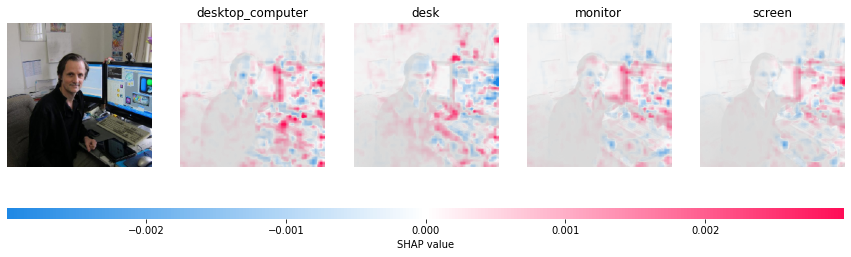

In [11]:
# plot the explanations
shap.image_plot(shap_values, inference_image, class_names)

From the above image, we can clearly see that based on the regions highlighted by the SHAP values how the model prediction is changing. When the model predicted the outcome as desktop computer, the region around the computer monitor keyboard and the desk got highlighted. Please observe that the man in the picture did not get highlighted. That is why the model did not predict the outcome as a man or human-being. Similarly, if you see that other possible predictions of desk monitor and screen, accordingly the different regions of the images are highlighted. This does provide a good explanation for the model outcome.

## Using Deep Explainers in SHAP

Now, let's use Deep Explainers in SHAP for Deep Learning models. But let's train a model from scratch in this example, instead of using pre-trained model architectures.

### Reloading the modules for this new section.

In [12]:
# load package
import shap
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import Input
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import cv2

### Preparing the data

In [13]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [14]:
x_train = x_train.reshape(50000, 32, 32, 3).astype("float32") / 255
x_test = x_test.reshape(10000, 32, 32, 3).astype("float32") / 255
y_train = y_train.reshape(50000,)
y_test = y_test.reshape(10000,)

### Define the model

In [15]:
# define the model architecture
inputs = Input(shape=(32, 32, 3))
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(64, activation='relu')(x)
outputs = keras.layers.Dense(10, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [16]:
# compile the model
model.compile(
      loss= 'sparse_categorical_crossentropy',
      optimizer= 'Adam',
      metrics=['sparse_categorical_accuracy']
  )
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs = 15)

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
49984/50000 [============================>.] - ETA: 0s - loss: 1.4308 - sparse_categorical_accuracy: 0.4854WARNING:tensorflow:From D:\Users\Aditya Bhattacharya\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
50000/50000 [==============================] - 6s 126us/sample - loss: 1.4307 - sparse_categorical_accuracy: 0.4855 - val_loss: 1.1984 - val_sparse_categorical_accuracy: 0.5747
Epoch 2/15
50000/50000 [==============================] - 6s 126us/sample - loss: 1.1121 - sparse_categorical_accuracy: 0.6076 - val_loss: 1.1752 - val_sparse_categorical_accuracy: 0.5788
Epoch 3/15
50000/50000 [==============================] - 6s 126us/sample - loss: 0.9626 - spar

From the model scores, we can see that our model has a good training accuracy, but not so good validation accuracy, indicating that the model is clearly over-fitting

In [17]:
# Classes in CIFAR-10 data
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [18]:
# Source : https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16
# Fetching an image for each of CIFAR-10 class
images_dict = dict()
for ind, label in enumerate(y_train):
    if len(images_dict)==10:
        break
    if label not in images_dict.keys():
        images_dict[label] = x_train[ind].reshape((32, 32,3))
images_dict = dict(sorted(images_dict.items()))

In [19]:
# Fetching an image for each of CIFAR-10 class for test set
x_test_dict = dict()
for ind, label in enumerate(y_test):
    if len(x_test_dict)==10:
        break
    if label not in x_test_dict.keys():
        x_test_dict[label] = x_test[ind]

# sorting
sample_x_test = [x_test_dict[i] for i in sorted(x_test_dict)]
sample_x_test = np.asarray(sample_x_test)

In [20]:
# Checking the predictions
predictions = model.predict(sample_x_test)
predicted_class = np.argmax(predictions, axis=1)

In [21]:
# Source : https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16
# plot actual and predicted class
def plot_actual_predicted(images, pred_classes):
    fig, axes = plt.subplots(2, 5, figsize=(16, 6))
    fig.tight_layout()
    axes = axes.flatten()
    ax = axes[0]
    # plot image
    for k,v in images.items():
        ax = axes[k]
        ax.imshow(cv2.resize(v, (512,512)), cmap=plt.cm.binary)
        ax.set_title(f"Original: %s \nPredicted: %s" % (class_names[k], class_names[pred_classes[k]]))
        ax.set_axis_off()
    plt.tight_layout()
    plt.show()

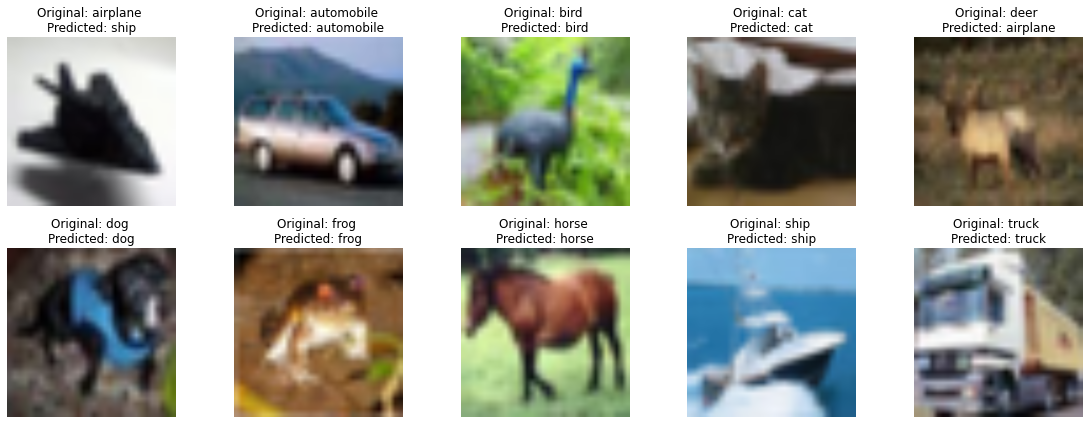

In [22]:
plot_actual_predicted(images_dict, predicted_class)

### SHAP Explainability

Now, we will use SHAP Deep Explainers to explain our model. First we will need to create a background set for SHAP and then compute Shapley values using Deep SHAP and visualize the same.

In [23]:
# Setting the backgroud for shap
background = x_train[np.random.choice(len(x_train), 1000, replace=False)]

# DeepExplainer to explain predictions of the model
explainer = shap.DeepExplainer(model, background)

# Computing the shap values
shap_values = explainer.shap_values(sample_x_test)

In [24]:
# Prepare the labels for display
labels = []
for i in range(10):
    labels.append(class_names)

<Figure size 1152x864 with 0 Axes>

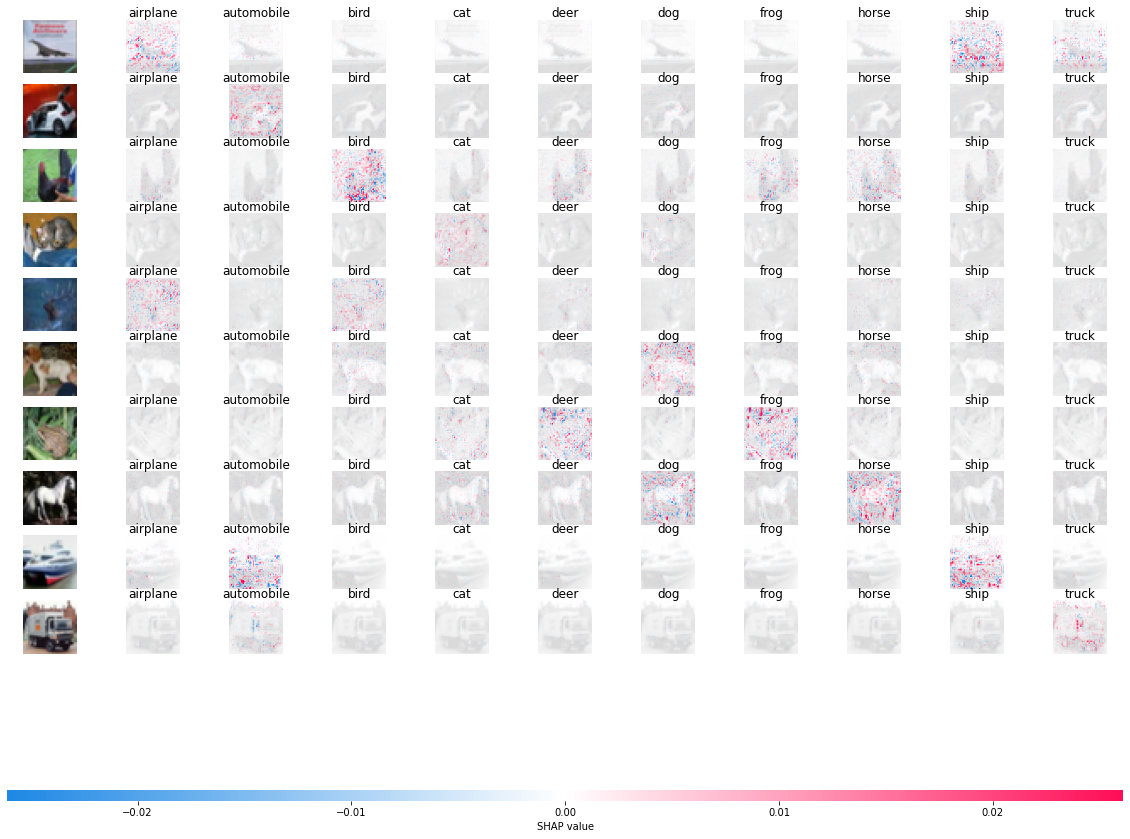

In [25]:
plt.figure(figsize=(16, 12))
shap.image_plot(shap_values, sample_x_test, labels, labelpad= 1)

In [26]:
for k in range(len(predicted_class)):
    print(class_names[predicted_class[k]])

ship
automobile
bird
cat
airplane
dog
frog
horse
ship
truck


## Final Thoughts

It was interesting to see how regions highlighted by SHAP values in red was actually related to the prediction class. I recommend looking at other tutorial examples provided by SHAP at https://github.com/slundberg/shap/tree/master/notebooks/image_examples and https://github.com/slundberg/shap/tree/master/notebooks/text_examples for applying SHAP with deep learning models trained on image and text data.

## Reference

1. SHAP GitHub Project - https://github.com/slundberg/shap
2. SHAP Documentations - https://shap.readthedocs.io/en/latest/index.html
3. SHAP Image Explainers - https://github.com/slundberg/shap/tree/master/notebooks/image_examples/image_classification
4. DeepExplainer Reference - "Deep Learning Model Interpretation Using SHAP" - https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16
4. Some of the utility functions and code are taken from the GitHub Repository of the author - Aditya Bhattacharya https://github.com/adib0073